# Preconditioned SGD: nearest-neighbour interpolation

A few plots (e.g. diagonal of the Hessian) when the forward model uses nearest-neighbour interpolation, in which case the Hessian matrix of the loss function is diagonal.

The resulting figures from this notebook are used in the the following manuscript:

[Toader, Brubaker and Lederman, *Efficient high-resolution refinement in cryo-EM with stochastic gradient descent*](https://arxiv.org/abs/2311.16100)

and can also be downloaded from Zenodo: [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.14017757.svg)](https://doi.org/10.5281/zenodo.14017757)

Running this notebook requires downloading the particle images in the Electron Microscopy Public Image Archive (EMPIAR) entry [EMPIAR-10076](https://www.ebi.ac.uk/empiar/EMPIAR-10076/) and inverting their contrast. The file with pose and CTF parameters is provided in [data/my_particles_8.star](data/my_particles_8.star).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
from jax import random, config
from tqdm import tqdm
import time
import mrcfile
import optax

from simplecryoem.emfiles import load_data
from simplecryoem.preprocess import preprocess
from simplecryoem.forwardmodel import Slice
from simplecryoem.optimization import (
    Loss,
    GradV,
    sgd,
    precon_sgd,
    get_sgd_vol_ops,
    oasis,
    oasis_adaptive,
)
from simplecryoem.utils import rescale_larger_grid, mip_x, mip_y, mip_z
from simplecryoem.fsc import calc_fsc, average_shells, average_shells_2D
from simplecryoem.ctf import eval_ctf

2024-10-15 14:40:27.459762: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 6, 6
config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_dir = '/ssd/Relion_10076_particles/'
star_file = 'my_particles_8.star'

params0, imgs0 = load_data(data_dir, star_file, load_imgs=True, fourier=False)

load_data: number of partcles: 33026
load_data: data loaded, time:  33.48 sec.


In [4]:
# Extract a subset with fixed seed key so that we always get the same subset.
# Larger sets must be supersets of the smaller sets respectively.

N0 = imgs0.shape[0]
nx0 = imgs0.shape[1]

subset_seed = 60
subset_key = random.PRNGKey(subset_seed)
idx_full = random.permutation(subset_key, N0)

print(subset_key)
print(idx_full[:10])

[ 0 60]
[10707  6049 19163  4747 28848 12283  6925  1608   809  3861]


In [5]:
out_dir =  "../../../simplecryoem_output/empiar_10076_8/"

nx_crop = 192 
N = 30000

idx = idx_full[:N]

In [6]:
save_figs = True
fig_dir =  "../../../simplecryoem_output/empiar_10076_8_figures/"

In [7]:
processed_data = preprocess(imgs0, params0, nx_crop=nx_crop, idx=idx)

imgs_f = processed_data["imgs_f"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]

imgs0.shape = (33026, 320, 320)
pixel_size0.shape = (33026,)
angles0.shape = (33026, 3)
shifts0.shape = (33026, 2)
ctf_params0.shape = (33026, 9)
N0 = 33026
idx provided
N = 30000
Taking FFT of the images:
Batch 1/10  4.67 sec.
Batch 2/10  4.67 sec.
Batch 3/10  4.69 sec.
Batch 4/10  4.64 sec.
Batch 5/10  4.65 sec.
Batch 6/10  4.66 sec.
Batch 7/10  4.65 sec.
Batch 8/10  4.67 sec.
Batch 9/10  4.67 sec.
Batch 10/10  4.66 sec.
FFT done. Time:  51.75 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 1.92000000e+02]
Vectorised imgs_f.shape = (30000, 36864)
Mask radius = 0.22662213740458012
Noise free, setting sigma_noise = 1


In [8]:
# Assuming these variables are the same for all images

pixel_size = processed_data["pixel_size"]
nx = processed_data["nx"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
x_grid = processed_data["x_grid"]
N = imgs_f.shape[0]

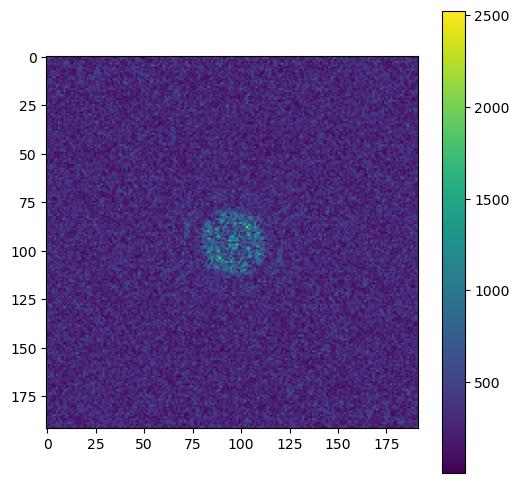

In [9]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[15].reshape([nx_crop, nx_crop]))))
plt.colorbar()

In [10]:
del imgs0

In [11]:
# Apply mask to images
apply_mask = True

if apply_mask:
    # mask2d = mask[0].reshape(-1)
    mask2d = mask[0].reshape(-1)
    imgs_f = imgs_f * mask2d
else:
    mask = jnp.ones(mask.shape)

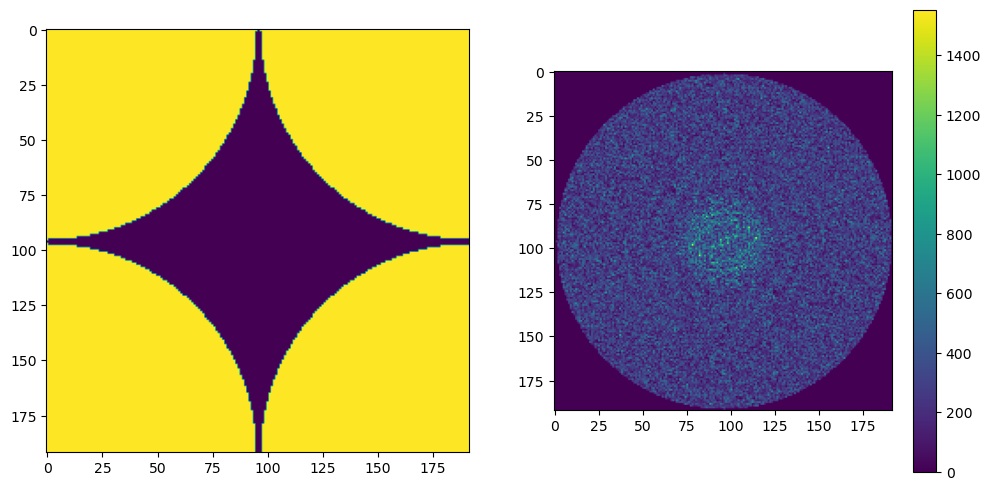

In [12]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(mask[0])

plt.subplot(1, 2, 2)
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[123].reshape([nx_crop, nx_crop]))))
plt.colorbar()

In [14]:
alpha = 1e-8 
interp_method = "nn"

slice_obj = Slice(x_grid, mask=mask, interp_method=interp_method)
loss_obj = Loss(slice_obj, alpha=alpha)
gradv_obj = GradV(loss_obj)

grad_func, loss_func, hvp_func, loss_px_func = get_sgd_vol_ops(
    gradv_obj, loss_obj, angles, shifts, ctf_params, imgs_f, sigma_noise
)

### Compute the Hessian diagonal exactly (valid for NN interpolation)

In [15]:
batch_sz = 100
n_batch = N // batch_sz
idx_batches = np.array_split(np.arange(N), n_batch)
ones = jnp.ones([nx,  nx, nx] , dtype=jnp.complex128)

D = np.zeros([nx, nx, nx], dtype=np.complex128)
for idx in idx_batches:
    D += hvp_func(ones, ones, idx)

D = jnp.array(D / n_batch)

9.999999999999937e-09
0.06113470364826185
6113470.364826224


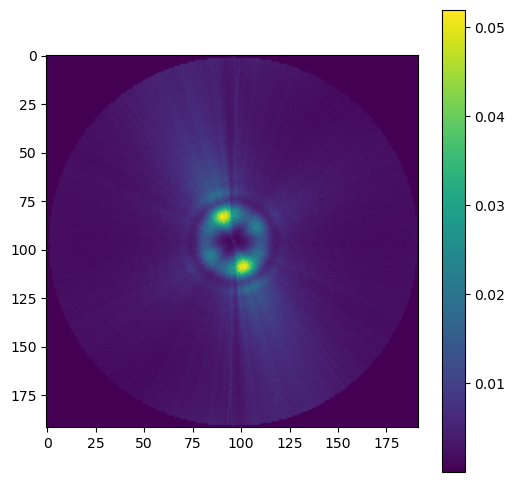

In [16]:
plt.imshow(jnp.fft.fftshift(jnp.abs(D[0, :, :])))
plt.colorbar()
print(jnp.min(jnp.abs(D)))
print(jnp.max(jnp.abs(D)))
print(jnp.max(jnp.abs(D)) / jnp.min(jnp.abs(D)))

#### Sanity check that the Hessian is indeed diagonal for NN interpolation and that I'm computing it correctly

Checking


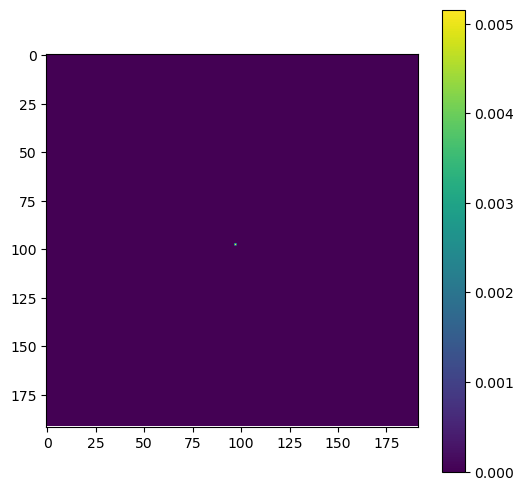

In [17]:
ei = jnp.zeros([nx, nx, nx], dtype=jnp.complex128)
ei = ei.at[0, 2, 1].set(1)
hvp = hvp_func(ones, ei, np.array([23, 1, 0, 6]))
plt.imshow(jnp.fft.fftshift(jnp.abs(hvp[0, :, :])))
plt.colorbar()

print("Checking")
# The only non-zero element of hvp must be hvpp[0, 2, 1]
assert jnp.abs(hvp[0, 2, 1] - jnp.sum(hvp)) == 0

Checking


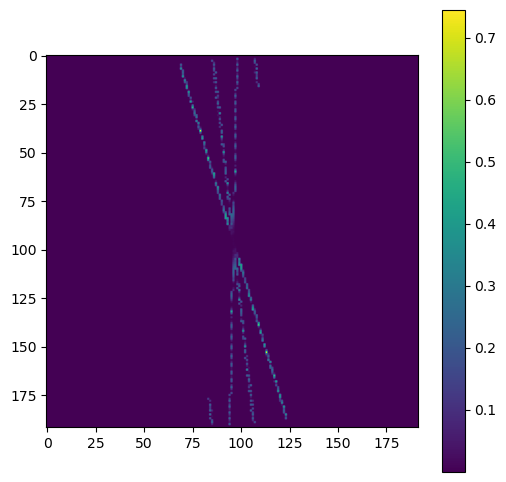

In [18]:
# Applying hvp_func to the one vector returns the diagonal of the matrix (if the matrix is diagonal).
ones = jnp.ones([nx, nx, nx], dtype=jnp.complex128)
hvp_diag = hvp_func(ones, ones, np.array([23, 1, 0, 6]))  # , 2345, 10000]))
plt.imshow(jnp.fft.fftshift(jnp.abs(hvp_diag[0, :, :])))
plt.colorbar()
print("Checking")
assert jnp.abs(hvp[0, 2, 1] - hvp_diag[0, 2, 1]) == 0

In [19]:
how_many = 5

ones = jnp.ones([nx, nx, nx], dtype=jnp.complex128)
hvp_diag = hvp_func(ones, ones, np.random.randint(N, size=how_many))

### And now some figures

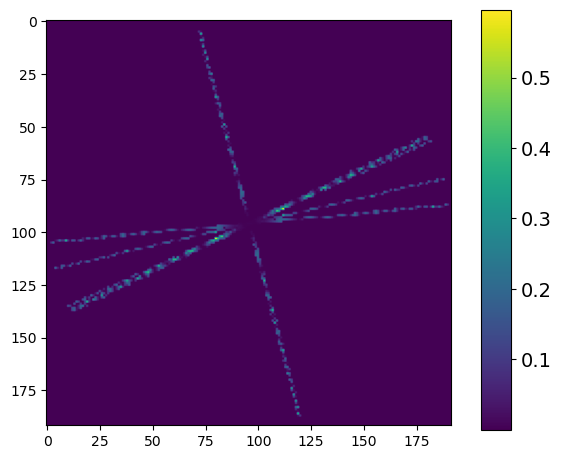

In [26]:
plt.rcParams["figure.figsize"] = 6, 6

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(jnp.fft.fftshift(jnp.abs(hvp_diag[0, :, :])))
# plt.title("Diagonal of $H$ for $N=5$", fontsize=22)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if save_figs:
    plt.savefig(
        f"{fig_dir}/preconditioner_{interp_method}_N{how_many}.eps", bbox_inches="tight"
    )

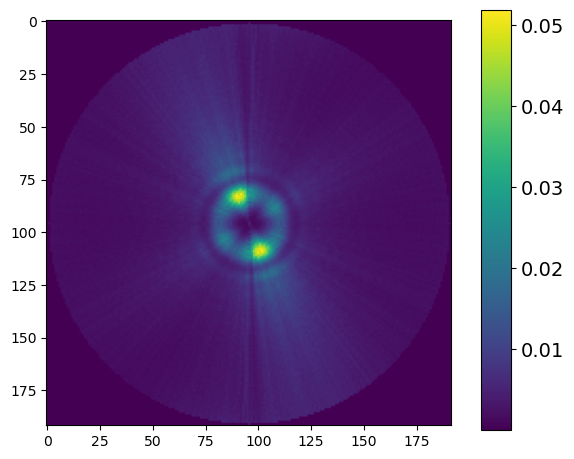

In [27]:
plt.rcParams['figure.figsize'] = 6, 6

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(jnp.fft.fftshift(jnp.abs(D[0, :, :])))
# plt.title("Diagonal of $H$ for $N=5$", fontsize=22)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if save_figs:
    plt.savefig(f'{fig_dir}/preconditioner_{interp_method}_N{N}.eps', bbox_inches='tight')

#### For the next cells, need to run L-BFGS with NN interpolation first, see older commits.

In [ ]:
v_lbfgs_slice = jnp.fft.fftshift(jnp.abs(v_lbfgs[0]))
hvp_diag_slice = jnp.fft.fftshift(jnp.abs(hvp_diag[0, :, :]))

In [ ]:
plt.imshow(v_lbfgs_slice)
plt.colorbar()
plt.clim([0, 4000])
plt.title("$v$", fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
if save_figs:
    plt.savefig(f'{fig_dir}/v_fft.eps')

In [ ]:
plt.imshow(v_lbfgs_slice * hvp_diag_slice)
plt.colorbar()
plt.clim(0, 40)
plt.title("$x_i$", fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
if save_figs:
    plt.savefig(f'{fig_dir}/xi_fft.eps')